#Imports and path setup

In [ ]:
# imports
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
#from google.colab.patches import cv_imshow
import cv2
import imgaug 
import imgaug as ia
import imgaug.augmenters as iaa
from sklearn.model_selection import train_test_split

In [ ]:
# define paths
bmp_path = '/kaggle/input'
op_path = '/kaggle/working'
circle_path = bmp_path + '/circles_new'
bamboo_path = bmp_path + '/bamboo'
image_path = bmp_path + '/minorproject'
train_image_path = image_path + '/train_images_latest'
true_image_path = image_path + '/true_images_new'
raw_masks_path = f"{bmp_path}/raw_masks_new/"
masks_path = f"{bmp_path}/masks_new/"

In [ ]:
# X = np.array(list(map(lambda a : image_path + '/' + a, os.listdir(image_path))))
# y = np.array(list(map(lambda a : true_image_path + '/' + a, os.listdir(true_image_path))))

In [ ]:
# print(X.shape)

(2,)


In [ ]:
# print(y.shape)

(2525,)


#Model

## Image generator

In [ ]:
# function for normalization
def normalize(input_image):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  # input_mask = tf.cast(input_mask, tf.float32) / 255.0
  return input_image

In [ ]:
# generate image dataset
img_dim = 256
batch_sz = 1
#Rescaling and Augmentation
image_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2,shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2,shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
#print(image_datagen.shape)

train_image_generator = image_datagen.flow_from_directory(
        image_path,
        target_size=(img_dim, img_dim),
        class_mode = None, #
        classes = ['train_images_latest'],
        batch_size = batch_sz,
        seed=42, #
        subset='training')
    
train_mask_generator = mask_datagen.flow_from_directory(
        image_path,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['true_images_new'],
        batch_size = batch_sz,
        seed=42, 
        subset='training')

val_image_generator = image_datagen.flow_from_directory(
        image_path,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['train_images_latest'],
        # color_mode='grayscale',
        batch_size = batch_sz,
        seed=42,
        subset='validation')
    
val_mask_generator = mask_datagen.flow_from_directory(
        image_path,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['true_images_new'],
        # color_mode='grayscale',
        batch_size = batch_sz,
        seed=42,
        subset='validation')

#image_datagen = ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
#mask_datagen = ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

Found 2020 images belonging to 1 classes.
Found 2020 images belonging to 1 classes.
Found 505 images belonging to 1 classes.
Found 505 images belonging to 1 classes.


In [ ]:
# image_datagen = ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
# mask_datagen = ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

In [ ]:
training_samples_size = train_image_generator.samples
val_samples_size = val_image_generator.samples
print(training_samples_size)
print(val_samples_size)

2020
505


##U-Net

In [ ]:
# batch/buffer sizes for NN
BATCH_SIZE = 8
#BUFFER_SIZE = 1000
# train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
# train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
# test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

In [ ]:
# custom convolution
def conv_block(input, num_filters):
  # First Conv2D layer
  x = layers.Conv2D(num_filters, 3, padding="same")(input)
  #x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.BatchNormalization()(x)
  # Second Conv2D layer
  x = layers.Conv2D(num_filters, 3, padding="same")(x)
  #x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.BatchNormalization()(x)
  
  return x

In [ ]:
# custom encoder
def encoder_block(input, num_filters):
  x = conv_block(input, num_filters)
  p = layers.MaxPool2D(2)(x)

  return x, p

In [ ]:
# custom decoder
def decoder_block(input, skip_features, num_filters):
  x = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')(input)
  x = layers.Concatenate()([skip_features, x])
  x = layers.Dropout(0.3)(x)
  x = conv_block(x, num_filters)

  return x

In [ ]:
# function to build unet
def build_unet_model(input_shape):
  inputs = layers.Input(shape=input_shape)

  # Encoders
  #s1, p1 = encoder_block(inputs,8)
  #s2, p2 = encoder_block(p1,16)
  s1, p1 = encoder_block(inputs,32)
  s2, p2 = encoder_block(p1,64)
  s3, p3 = encoder_block(p2,128)
  s4, p4 = encoder_block(p3, 256)
  #s6, p6 = encoder_block(p5, 512)
  # s5, p5 = encoder_block(p4, 1024)

  # Base
  b = conv_block(p4, 256)

  # Decoders
  # d = decoder_block(b, s5, 1024)
  #d1 = decoder_block(b, s6, 512)
  d1 = decoder_block(b, s4, 256)
  d2 = decoder_block(d1, s3, 128)
  d3 = decoder_block(d2, s2, 64)
  d4 = decoder_block(d3, s1, 32)
  #d5 = decoder_block(d4, s2, 16)
  #d6 = decoder_block(d5, s1, 8)
  

  # Output
  outputs = layers.Conv2D(3, 3, padding='same', activation='relu')(d4)

  # UNet model 
  unet_model = keras.Model(inputs, outputs, name='U-Net')

  return unet_model

In [ ]:
#SSIM metrics
def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1)

def ape(y_true, y_pred):
  return tf.keras.losses.MeanAbsolutePercentageError(y_true, y_pred)

In [ ]:
# build model
unet_model = build_unet_model((img_dim, img_dim, 3))

In [ ]:
# unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
#                   loss="MSE",
#                   metrics=[ssim, tf.keras.metrics.MeanAbsolutePercentageError()])
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="MSE",
                  metrics=[ssim])

In [ ]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 32  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
# save model
model_path = op_path + "/unet4.h5"
checkpoint = keras.callbacks.ModelCheckpoint(model_path,
                             monitor="loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

# earlystop = keras.callbacks.EarlyStopping(monitor = 'loss', 
#                           min_delta = 0, 
#                           patience = 5,
#                           verbose = 1,
#                           restore_best_weights = True)

In [ ]:
history = unet_model.fit(train_generator,
                    steps_per_epoch=training_samples_size//BATCH_SIZE,
                    validation_data=val_generator,
                    validation_steps=val_samples_size//BATCH_SIZE,
                    epochs=100, callbacks=[checkpoint])

Epoch 1/100


2023-04-20 14:35:37.345363: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-Net/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


252/252 [==============================] - ETA: 0s - loss: 0.0461 - ssim: 0.5725
Epoch 1: loss improved from inf to 0.04607, saving model to /kaggle/working/unet4.h5
252/252 [==============================] - 39s 81ms/step - loss: 0.0461 - ssim: 0.5725 - val_loss: 0.2915 - val_ssim: 0.0036
Epoch 2/100
252/252 [==============================] - ETA: 0s - loss: 0.0072 - ssim: 0.8120
Epoch 2: loss improved from 0.04607 to 0.00720, saving model to /kaggle/working/unet4.h5
252/252 [==============================] - 20s 79ms/step - loss: 0.0072 - ssim: 0.8120 - val_loss: 0.0074 - val_ssim: 0.8803
Epoch 3/100
252/252 [==============================] - ETA: 0s - loss: 0.0040 - ssim: 0.8623
Epoch 3: loss improved from 0.00720 to 0.00404, saving model to /kaggle/working/unet4.h5
252/252 [==============================] - 20s 80ms/step - loss: 0.0040 - ssim: 0.8623 - val_loss: 0.0029 - val_ssim: 0.9141
Epoch 4/100
252/252 [==============================] - ETA: 0s - loss: 0.0029 - ssim: 0.8839
Ep

In [ ]:
import pickle
with open('/kaggle/working/history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
print(type(history.history))

<class 'dict'>


In [ ]:
def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1)
  
dependencies = {
    'ssim': ssim
}

In [ ]:
model = keras.models.load_model('/kaggle/working/unet4.h5', custom_objects=dependencies)
#model = keras.models.load_model('/kaggle/input/unetmodel/unet4.h5', custom_objects=dependencies)

In [ ]:
import pickle
with open('/kaggle/working/history.pkl', 'rb') as f:
    history = pickle.load(f)

In [ ]:
import seaborn as sns
sns.set_style('dark')

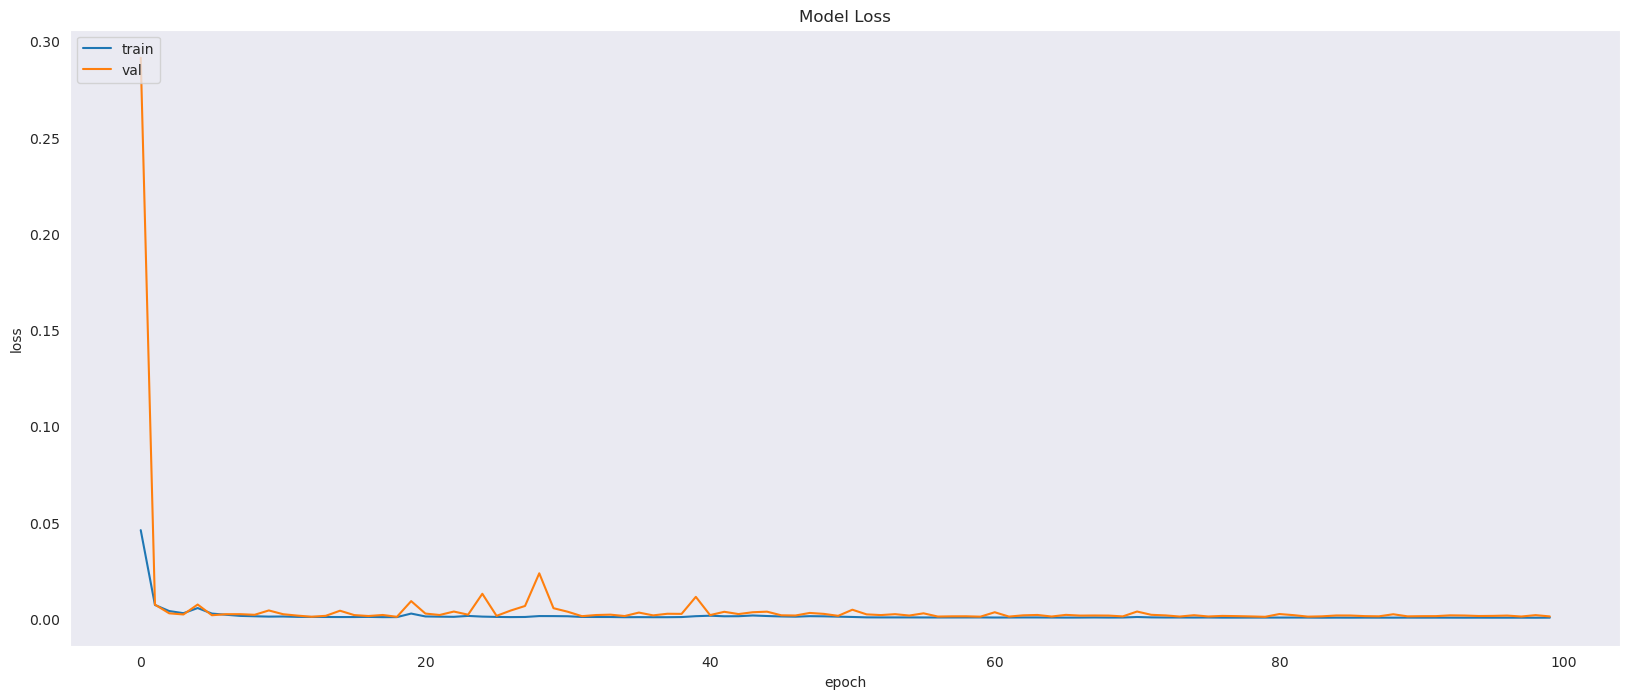

In [ ]:
plt.figure(figsize=(20,8))
loss = history['loss']
val_loss = history['val_loss']
length = len(loss)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
#plt.xticks(range(16), range(5,21))

plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

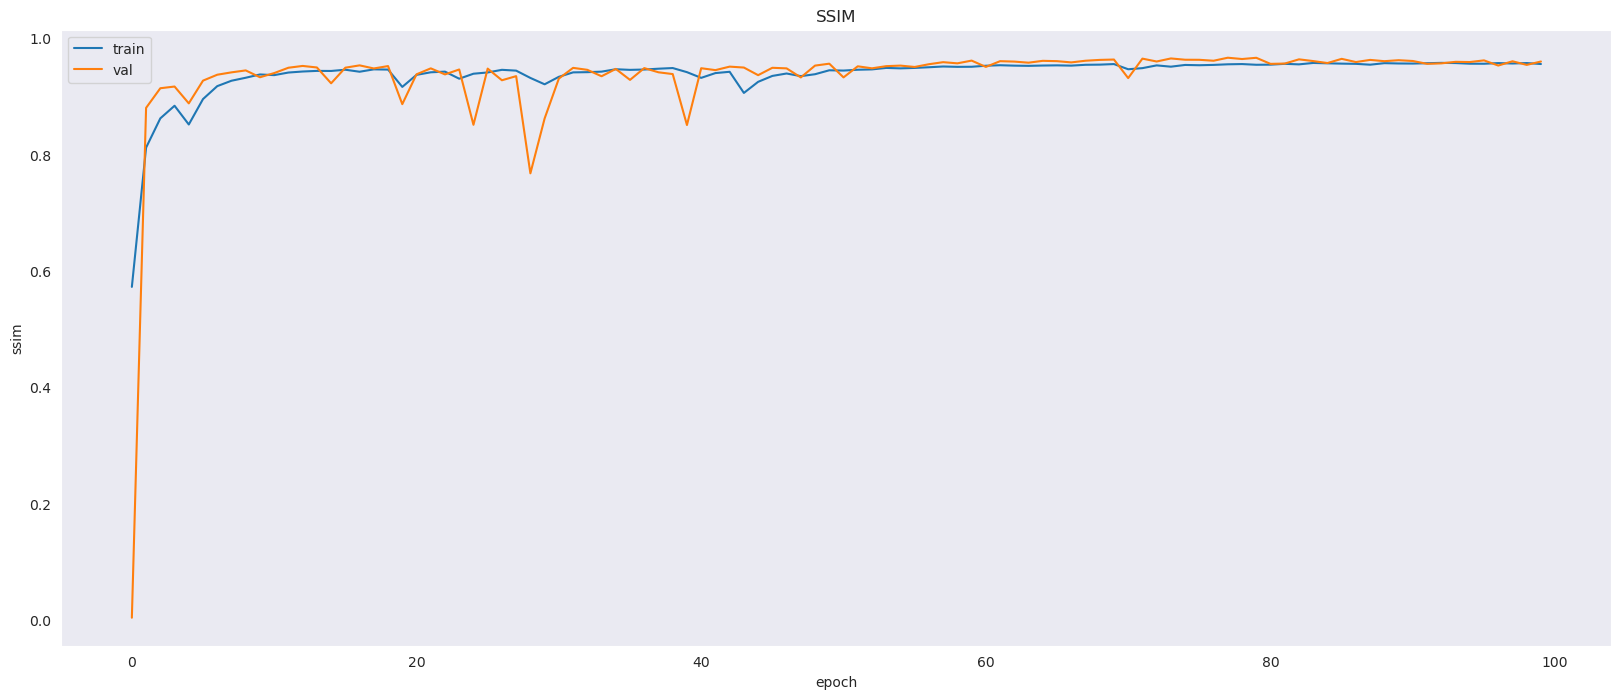

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history['ssim'])
plt.plot(history['val_ssim'])
plt.title('SSIM')
plt.ylabel('ssim')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()